#Giorgio Mendoza

#CS539-F23-F02

#Dr. J. Sethi


# Lab 5-1: Model Selection: Classification

## Data

We will use Mortgage Affordability data from Zillow to experiment with classification algorithms. The data was downloaded from [Zillow Research](https://www.zillow.com/research/data/) page. Please download the Affordability_Wide_2017Q4_Public.csv file to your project directory.

## Preparing the data

First, we will tidy the data. Please include this piece of code in your submission.

In [ ]:
import pandas as pd
import numpy as np
from plotnine import *
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Colab Notebooks/Affordability_Wide_2017Q4_Public.xlsx'

theme_set(theme_bw())

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from plotnine import *
from google.colab import drive

# Mount Google Drive to access your data file
drive.mount('/content/drive')

# Define the file path for your CSV dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/Affordability_Wide_2017Q4_Public.csv'

# Set the theme for plotting
theme_set(theme_bw())

# Read and prepare data
# Read the data from the CSV file using the 'file_path' variable
df = (pd.read_csv(file_path)  # Use pd.read_csv() for CSV files
        # Filter rows where 'Index' is "Mortgage Affordability" and 'SizeRank' is not equal to 0
        .query('Index == "Mortgage Affordability" and SizeRank != 0')
        # Drop unnecessary columns
        .drop(columns=['Index', 'HistoricAverage_1985thru1999', 'SizeRank'])
        # Drop rows with missing values
        .dropna()
        # Reshape the data using 'melt' to have a long format
        .melt(id_vars=['RegionID', 'RegionName'],
              var_name='time', value_name='affordability'))

# Convert the 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'], format="%Y-%m")

# Display the first few rows of the DataFrame
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,RegionID,RegionName,time,affordability
0,394913,"New York, NY",1979-03-01,0.261700
1,753899,"Los Angeles-Long Beach-Anaheim, CA",1979-03-01,0.357694
2,394463,"Chicago, IL",1979-03-01,0.261928
3,394514,"Dallas-Fort Worth, TX",1979-03-01,0.301131
4,394974,"Philadelphia, PA",1979-03-01,0.204333


This is what the data looks like:

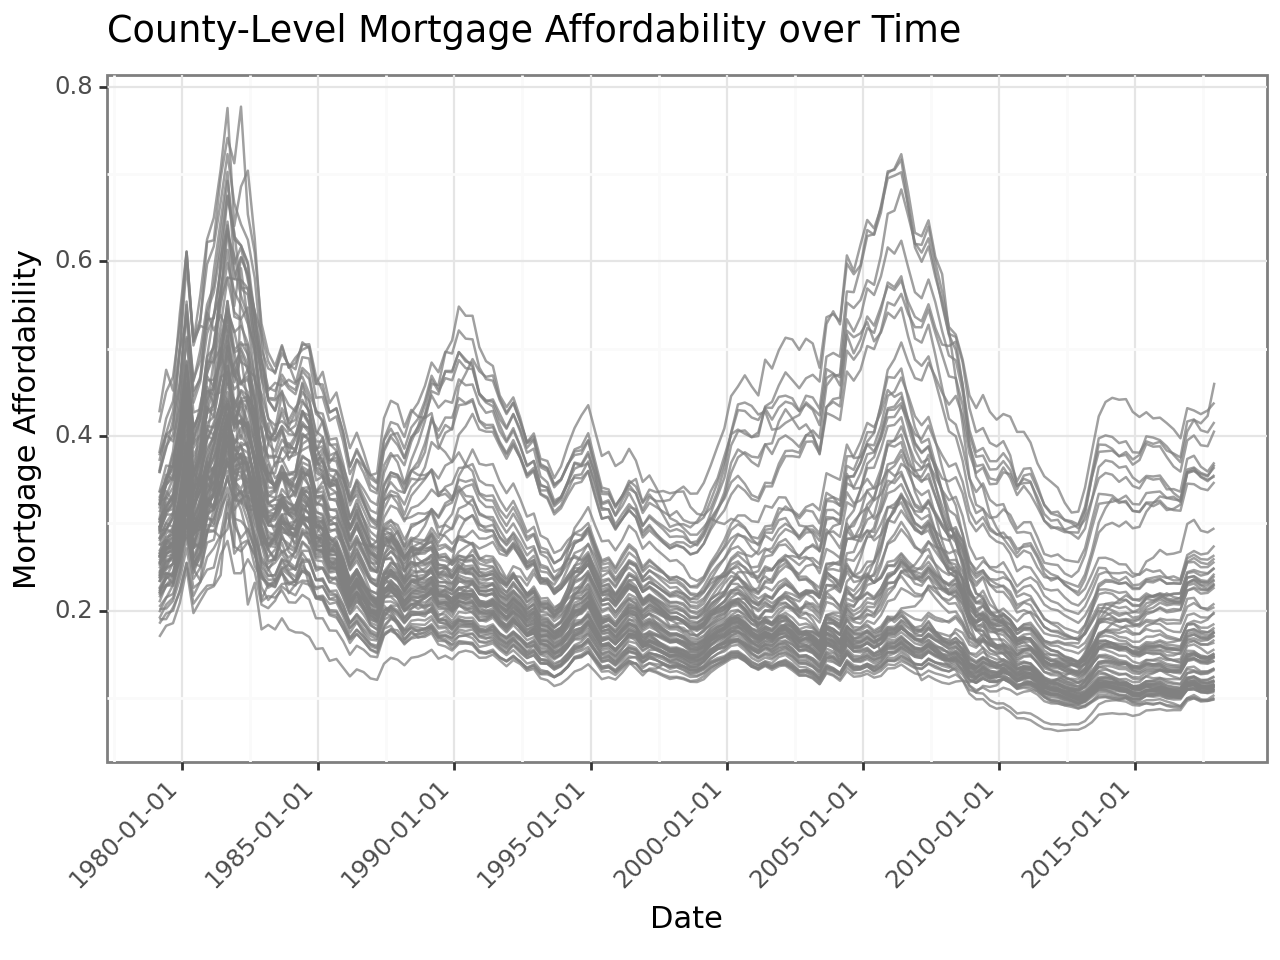

<Figure Size: (640 x 480)>

In [ ]:
# plot data

(ggplot(df, aes(x='time', y='affordability', group='factor(RegionID)')) +
  geom_line(color="GRAY", alpha=3/4, size=1/2) +
  theme(axis_text_x=element_text(angle=45,hjust=1)) +
  labs(title="County-Level Mortgage Affordability over Time",
          x="Date", y="Mortgage Affordability"))

## The prediction task

The prediction task we are going to answer is: `Can we predict if mortgage affordability will increase or decrease a year from now?` Specifically, we will do this for quarter 4 (Q4) of 2017. To create the prediction outcome, we will compare affordability for Q4 of 2017 to Q4 of 2016 and label it as `up` or `down`, depending on the sign of the this difference. Let's create the outcome we want to predict (again, copy this bit of code to your submission):

In [ ]:
outcome_dates = ['2016-12-01', '2017-12-01']
outcome_df = (df.query('time in @outcome_dates')
   .pivot(index='RegionID', columns='time', values='affordability'))

outcome_df['diff'] = outcome_df['2017-12-01'] - outcome_df['2016-12-01']
outcome_df['Direction'] = 'Down'
outcome_df['Direction'] = outcome_df['Direction'].where(outcome_df['diff'] < 0, 'Up') # this replaces where conditions is False
outcome_df = outcome_df.reset_index()[['RegionID','Direction']]
outcome_df.head()

time,RegionID,Direction
0,394304,Down
1,394312,Down
2,394318,Down
3,394347,Up
4,394355,Up


Now you have a dataframe with outcomes (labels) for each county in the dataset. The goal is then:  given predictors $X_i$ for county $i$, build a classifier for outcome $G_i \in \{\mathtt{up},\mathtt{down}\}$.

To train your classifiers you should use data up to 2016:

In [ ]:
predictor_df = df.query('time < 20170101')

## Your Project's Goal
Your goal for this project is to do an experiment to address a (one, single) technical question about our ability to make this prediction. Here is a list of possible questions you may address below. Each of them asks to compare two specific choices in the classification workflow (e.g., two classification algorithms, two feature representations, etc.).

You will *implement* each of the two choices and use *10-fold cross validation* (across RegionID's) to compare their relative performance. You will also create an *AUROC curve* to compare them.

## Possible Questions

### Feature representation and preprocessing
- Does standardizing affordability for each region affect  prediction performance? Compare standardized to non-standardized affordability.
- Is using quarter to quarter change (continuous or discrete) improve prediction performance? Compare quarter to quarter change in affordability as predictors to affordability as predictor?
- Should we use the full time series for each region, or should we use only the last few years? Compare full time series to a subset of the time series?
- Should we expand the training set to multiple time series per region? For example, create a similar outcome for each time point in the dataset (change relative to affordability one year ago) and use data from the last couple of years as predictors. Train on the extended dataset and test on the 2017 data above?
- Should we do dimensionality reduction (PCA) and use the embedded data to do prediction?

*Create your own question!*

### Classification Algorithm

- Is a decision tree better than logistic regression?
- Is a random forest better than a decision tree?
- Is k-nearest neighbors better than a random forest?

*Create your own question!*

Note that you still have to make some choices regardless of the question you choose. For example, to do the feature preprocessing and representation experiments you have to choose a classifier (random forest for example), and decide what to do about hyper-parameters if appropriate.

# Submission
Prepare a Jupyter/IPython notebook that which includes:

1. Code to prepare data (copied from chunks above), plus any additional data prep for your experiment
2. Discussion of the question you have chosen to address, including discussion of other choices you have made (e.g., feature representation, classification algorithm) to carry out your experiment
3. Code to carry out your cross-validation experiment
4. Table (result of hypothesis testing difference between algorithms) and plot comparing AUROCs
	* ROC curves for both experimental settings
5. Interpretation and discussion of your experimental results


# An example experiment

Question: Does the number of trees used in a random forest classifier affect performance (AUROC measured with 5-fold CV)?

Other decisions: We are transforming input data to use quarterly differences after data standardization for years 2014-2016.

## Data preparation

First, filter to the years of interest and standardize affordability for each region.

In [ ]:
# Subset data and compute mean and standard deviation per region
tmp_df = predictor_df.query('time > 20131201 & time < 20170101')
stat_df = tmp_df.groupby('RegionID').agg({'affordability': ['mean', 'std']})
stat_df.columns = stat_df.columns.get_level_values(1)
stat_df.reset_index(col_level=1).set_index('RegionID')

# Standardize affordability for each region
std_df = tmp_df.set_index('RegionID').join(stat_df)
std_df['std_affordability'] = (std_df['affordability'] - std_df['mean'])/std_df['std']
std_df.head()

,RegionName,time,affordability,mean,std,std_affordability
RegionID,,,,,,
394304,"Akron, OH",2014-03-01,0.110923,0.108193,0.003617,0.754555
394304,"Akron, OH",2014-06-01,0.109178,0.108193,0.003617,0.272298
394304,"Akron, OH",2014-09-01,0.108367,0.108193,0.003617,0.047965
394304,"Akron, OH",2014-12-01,0.104267,0.108193,0.003617,-1.085563
394304,"Akron, OH",2015-03-01,0.103859,0.108193,0.003617,-1.198250


To train our model we need a table with one row per region, and attributes corresponding to differences in quarterly affordability. We will do this in stages, first we turn the tidy dataset into a wide dataset using `pd.pivot` then create a dataframe containing the differences we use as features.

In [ ]:
# Switch to a 'wide' data frame
std_df['RegionID'] = std_df.index
std_df = (std_df[['RegionID','time','std_affordability']]
  .pivot(index='RegionID', columns='time', values='std_affordability'))

# Construct matrix of quarterly differences
mat1 = std_df.iloc[:,1:].to_numpy()
mat2 = std_df.iloc[:,:-1].to_numpy()
X = mat1 - mat2

# Get the outcome from the dataframe we created
outcome_df['y'] = 0
outcome_df['y'] = outcome_df['y'].where(outcome_df['Direction'] == "Down", 1)
y = outcome_df['y'].to_numpy()

## Run the experiment

We will only use 5-fold cross-validation to compare a random forest with 500 trees, with a random forest with 10 trees. Since this is a smallish dataset,  we are using 5-fold cross validation to make the validation sets have more examples and therefore more reliable performance estimates.

In [ ]:
import sklearn.ensemble
import sklearn.model_selection
import sklearn.metrics
import matplotlib.pylab as plt
import numpy as np

In [ ]:
small_rf = sklearn.ensemble.RandomForestClassifier(n_estimators=10)
big_rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)

parameters = {'max_features': [2,6,11]} # we do this to match what the R version did
small_cv = sklearn.model_selection.GridSearchCV(small_rf, parameters, cv=5)
big_cv = sklearn.model_selection.GridSearchCV(big_rf, parameters, cv=5)

# Following sklearn tutorial
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
cv_obj = sklearn.model_selection.StratifiedKFold(n_splits=5)


def get_roc_data(model, cv_obj):
    curve_df = None
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train, test) in enumerate(cv_obj.split(X, y)):
        model.fit(X[train], y[train])
        scores = model.predict_proba(X[test])[:,1]
        fpr, tpr, _ = sklearn.metrics.roc_curve(y[test],scores)

        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tmp = pd.DataFrame({'fold':i, 'fpr': mean_fpr, 'tpr': interp_tpr})
        curve_df = tmp if curve_df is None else pd.concat([curve_df, tmp])

        aucs.append(sklearn.metrics.auc(fpr, tpr))

    curve_df = curve_df.groupby('fpr').agg({'tpr': 'mean'}).reset_index()
    curve_df.iloc[-1,1] = 1.0

    auc_df = pd.DataFrame({'fold': np.arange(len(aucs)), 'auc': aucs})
    return curve_df, auc_df

In [ ]:
# Get ROC curve data for small model
small_curve_df, small_auc_df = get_roc_data(small_cv, cv_obj)
small_curve_df['model'] = 'small'
small_auc_df['model'] = 'small'

In [ ]:
# Get ROC curve data for big model
big_curve_df, big_auc_df = get_roc_data(big_cv, cv_obj)
big_curve_df['model'] = 'big'
big_auc_df['model'] = 'big'

In [ ]:
# Combine the ROC curve data
curve_df = pd.concat([small_curve_df, big_curve_df])
auc_df = pd.concat([small_auc_df, big_auc_df])

auc_df

,fold,auc,model
0,0,0.383333,small
1,1,0.533333,small
2,2,0.425000,small
3,3,0.325000,small
4,4,0.772727,small
0,0,0.441667,big
1,1,0.566667,big
2,2,0.608333,big
3,3,0.450000,big
4,4,0.618182,big


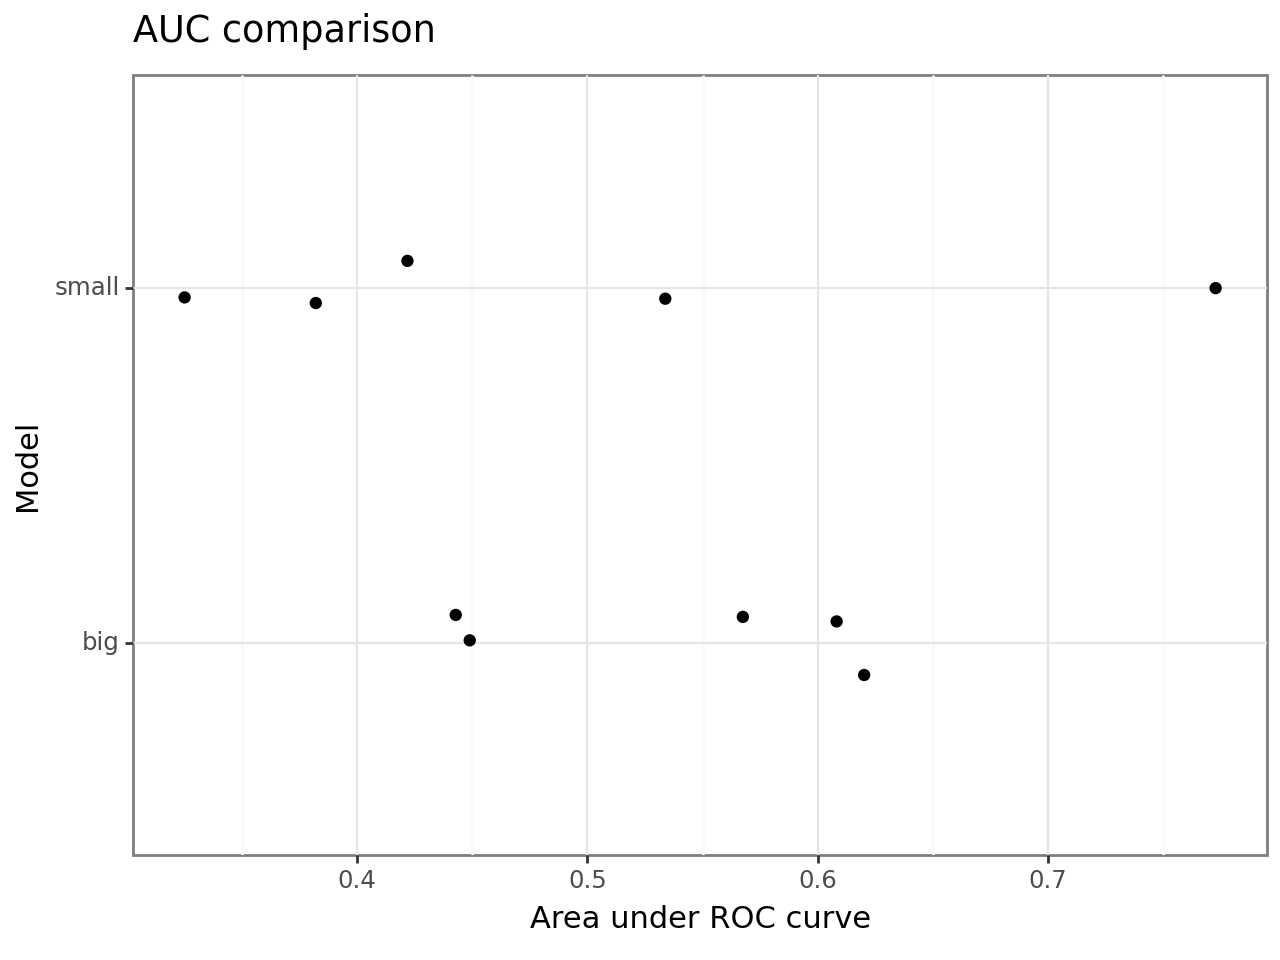

<Figure Size: (640 x 480)>

In [ ]:
# Plot the distribution of auc estimates
(ggplot(auc_df, aes(x='model', y='auc')) +
     geom_jitter(position=position_jitter(0.1)) +
     coord_flip() +
     labs(title = "AUC comparison",
          x="Model",
          y="Area under ROC curve"))

We can also test for differences using linear regression:

In [ ]:
# Use a two-sided test (based on linear regression) to see if there is a
# statistically significant difference in auc estimates
import statsmodels.formula.api as smf
lm_fit = smf.ols('auc~model', data=auc_df).fit()

In [ ]:
lm_fit.summary()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    auc   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                 -0.083
Method:                 Least Squares   F-statistic:                    0.3133
Date:                Tue, 05 Dec 2023   Prob (F-statistic):              0.591
Time:                        05:23:38   Log-Likelihood:                 6.6829
No. Observations:                  10   AIC:                            -9.366
Df Residuals:                       8   BIC:                            -8.761
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.5370      0.062      8.659      0.000       0.394       0.680
model[T.small]    -0.0491      0.088     -0.560      0.591      -0.251       0.153
==============================================================================
Omnibus:                        3.586   Durbin-Watson:                   2.990
Prob(Omnibus):                  0.166   Jarque-Bera (JB):                1.328
Skew:                           0.886   Prob(JB):                        0.515
Kurtosis:                       3.227   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is a small decrease (2.8%) in average AUROC for the small model but it is not a statistically significant difference.

Finally, here are the ROC curves for both models:

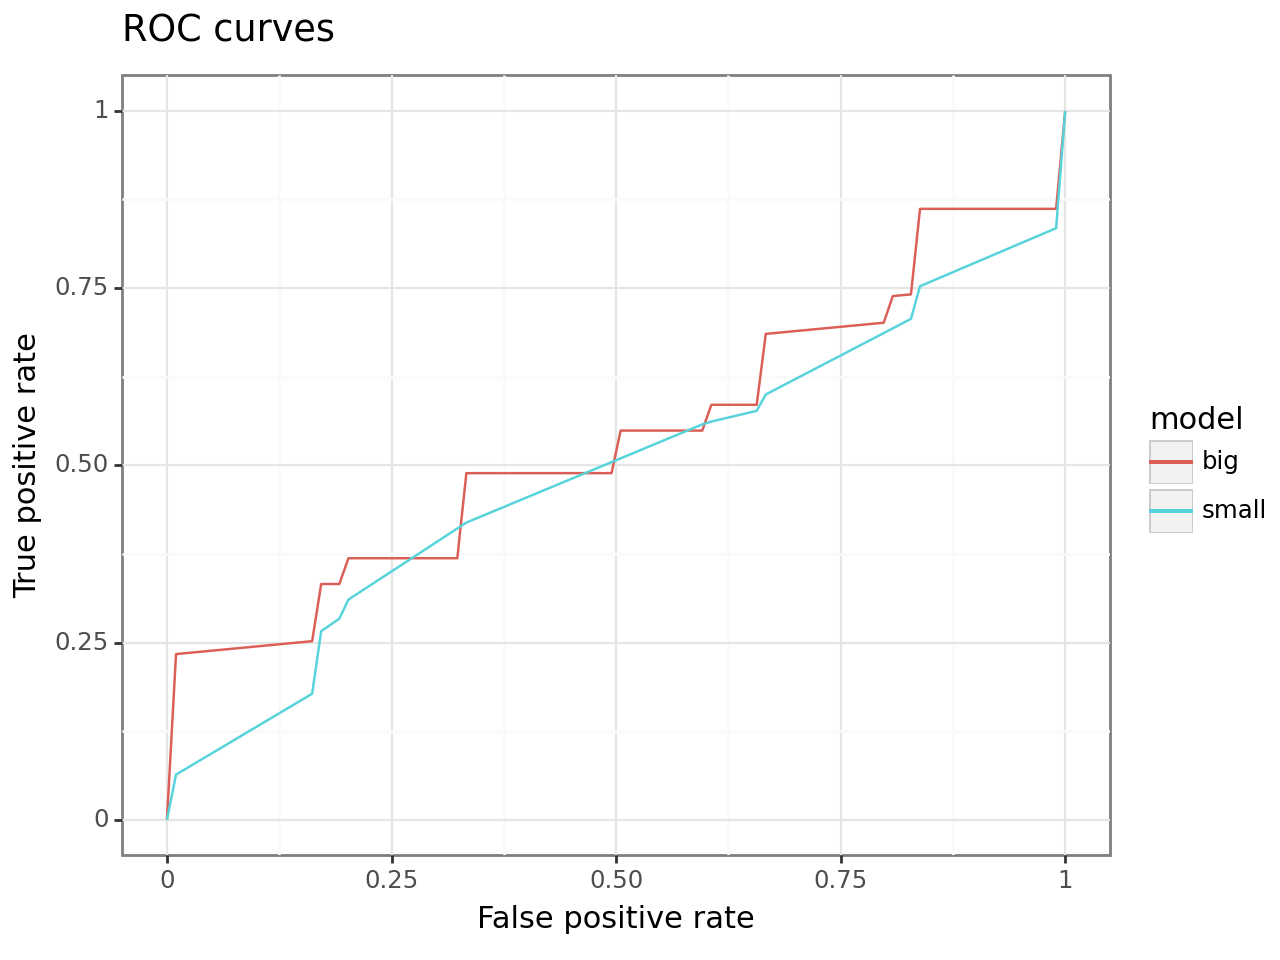

<Figure Size: (640 x 480)>

In [ ]:
mean_curve_df = curve_df.groupby(['model','fpr']).agg({'tpr': 'mean'}).reset_index()
(ggplot(mean_curve_df, aes(x='fpr', y='tpr', color='model')) +
    geom_line() +
    labs(title = "ROC curves",
         x = "False positive rate",
         y = "True positive rate"))

There is a small difference in the low false positive rate between the models but, essentially, these models perform very similarly. Neither model is very good at this task apparently.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score

# Assuming 'df' and 'outcome_df' are already defined

# Subset data and compute mean and standard deviation per region
tmp_df = df.query('time > "2013-12-01" & time < "2017-01-01"')
stat_df = tmp_df.groupby('RegionID').agg({'affordability': ['mean', 'std']}).reset_index()
stat_df.columns = ['RegionID', 'mean', 'std']  # Flatten the MultiIndex

# Standardize affordability for each region
std_df = tmp_df.merge(stat_df, on='RegionID')
std_df['std_affordability'] = (std_df['affordability'] - std_df['mean']) / std_df['std']

# Turn the tidy dataset into a 'wide' format with one row per region
wide_df = (std_df.pivot(index='RegionID', columns='time', values='std_affordability'))

# Construct a matrix of quarterly differences
mat1 = wide_df.iloc[:, 1:].to_numpy()
mat2 = wide_df.iloc[:, :-1].to_numpy()
X = mat1 - mat2  # Predictor features

# Update 'outcome_df' to ensure it's properly aligned
outcome_df = outcome_df.reset_index()
outcome_df['y'] = outcome_df['Direction'].apply(lambda x: 1 if x == 'Up' else 0)

# Align the outcome with the features
y = outcome_df.set_index('RegionID').reindex(wide_df.index)['y'].to_numpy()

# Initialize the Random Forest classifier
classifier = RandomForestClassifier()

# Define the cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Using 5-fold as per your snippet

# Perform cross-validation and calculate AUROC scores
auroc_scores = cross_val_score(
    classifier,
    X,
    y,
    scoring=make_scorer(roc_auc_score),
    cv=kf
)

# Print the average AUROC score across all cross-validation folds
print(f"Average AUROC score across all folds: {np.mean(auroc_scores)}")


Average AUROC score across all folds: 0.490952380952381


In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# Load your dataset as a pandas DataFrame
file_path = '/content/drive/MyDrive/Colab Notebooks/Affordability_Wide_2017Q4_Public.csv'
df = (pd.read_csv(file_path)
      .query('Index == "Mortgage Affordability" and SizeRank != 0')
      .drop(columns=['Index', 'HistoricAverage_1985thru1999', 'SizeRank'])
      .dropna()
      .melt(id_vars=['RegionID', 'RegionName'], var_name='time', value_name='affordability'))

# Convert the 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'], format="%Y-%m")

# Create outcome_df
outcome_dates = ['2016-12-01', '2017-12-01']
outcome_df = (df.query('time in @outcome_dates')
              .pivot(index='RegionID', columns='time', values='affordability'))
outcome_df['diff'] = outcome_df['2017-12-01'] - outcome_df['2016-12-01']
outcome_df['Direction'] = outcome_df['diff'].apply(lambda x: 'Up' if x > 0 else 'Down')
outcome_df = outcome_df.reset_index()[['RegionID', 'Direction']]

# Prepare predictor_df
predictor_df = df.query('time < "2017-01-01"').groupby('RegionID').agg({'affordability':'mean'}).reset_index()

# Join predictor_df with outcome_df
full_df = predictor_df.merge(outcome_df, on='RegionID')

# Select features for prediction and the target variable
X = full_df[['affordability']].values
y = full_df['Direction'].map({'Up': 1, 'Down': 0}).values

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize classifiers
decision_tree = DecisionTreeClassifier(random_state=42)
logistic_reg = LogisticRegression(random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# Standardize the data
X_standardized = scaler.fit_transform(X)

# Create a dictionary to store models and their names
models = {
    'Decision Tree Non-Standardized': decision_tree,
    'Decision Tree Standardized': DecisionTreeClassifier(random_state=42),
    'Logistic Regression Non-Standardized': logistic_reg,
    'Logistic Regression Standardized': LogisticRegression(random_state=42)
}

# Create a dictionary to store the AUC scores for each model
model_aucs = {name: [] for name in models.keys()}

# Perform the experiment
for name, model in models.items():
    if 'Standardized' in name:
        # Use standardized data
        aucs = cross_val_score(model, X_standardized, y, scoring='roc_auc', cv=cv)
    else:
        # Use non-standardized data
        aucs = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)

    model_aucs[name] = aucs

# Print the results
for name, aucs in model_aucs.items():
    print(f"{name} - AUC: {aucs.mean()} ± {aucs.std()}")


Decision Tree Non-Standardized - AUC: 0.533030303030303 ± 0.12665216677918406
Decision Tree Standardized - AUC: 0.533030303030303 ± 0.12665216677918406
Logistic Regression Non-Standardized - AUC: 0.5963636363636364 ± 0.10191283479187893
Logistic Regression Standardized - AUC: 0.5963636363636364 ± 0.10191283479187893


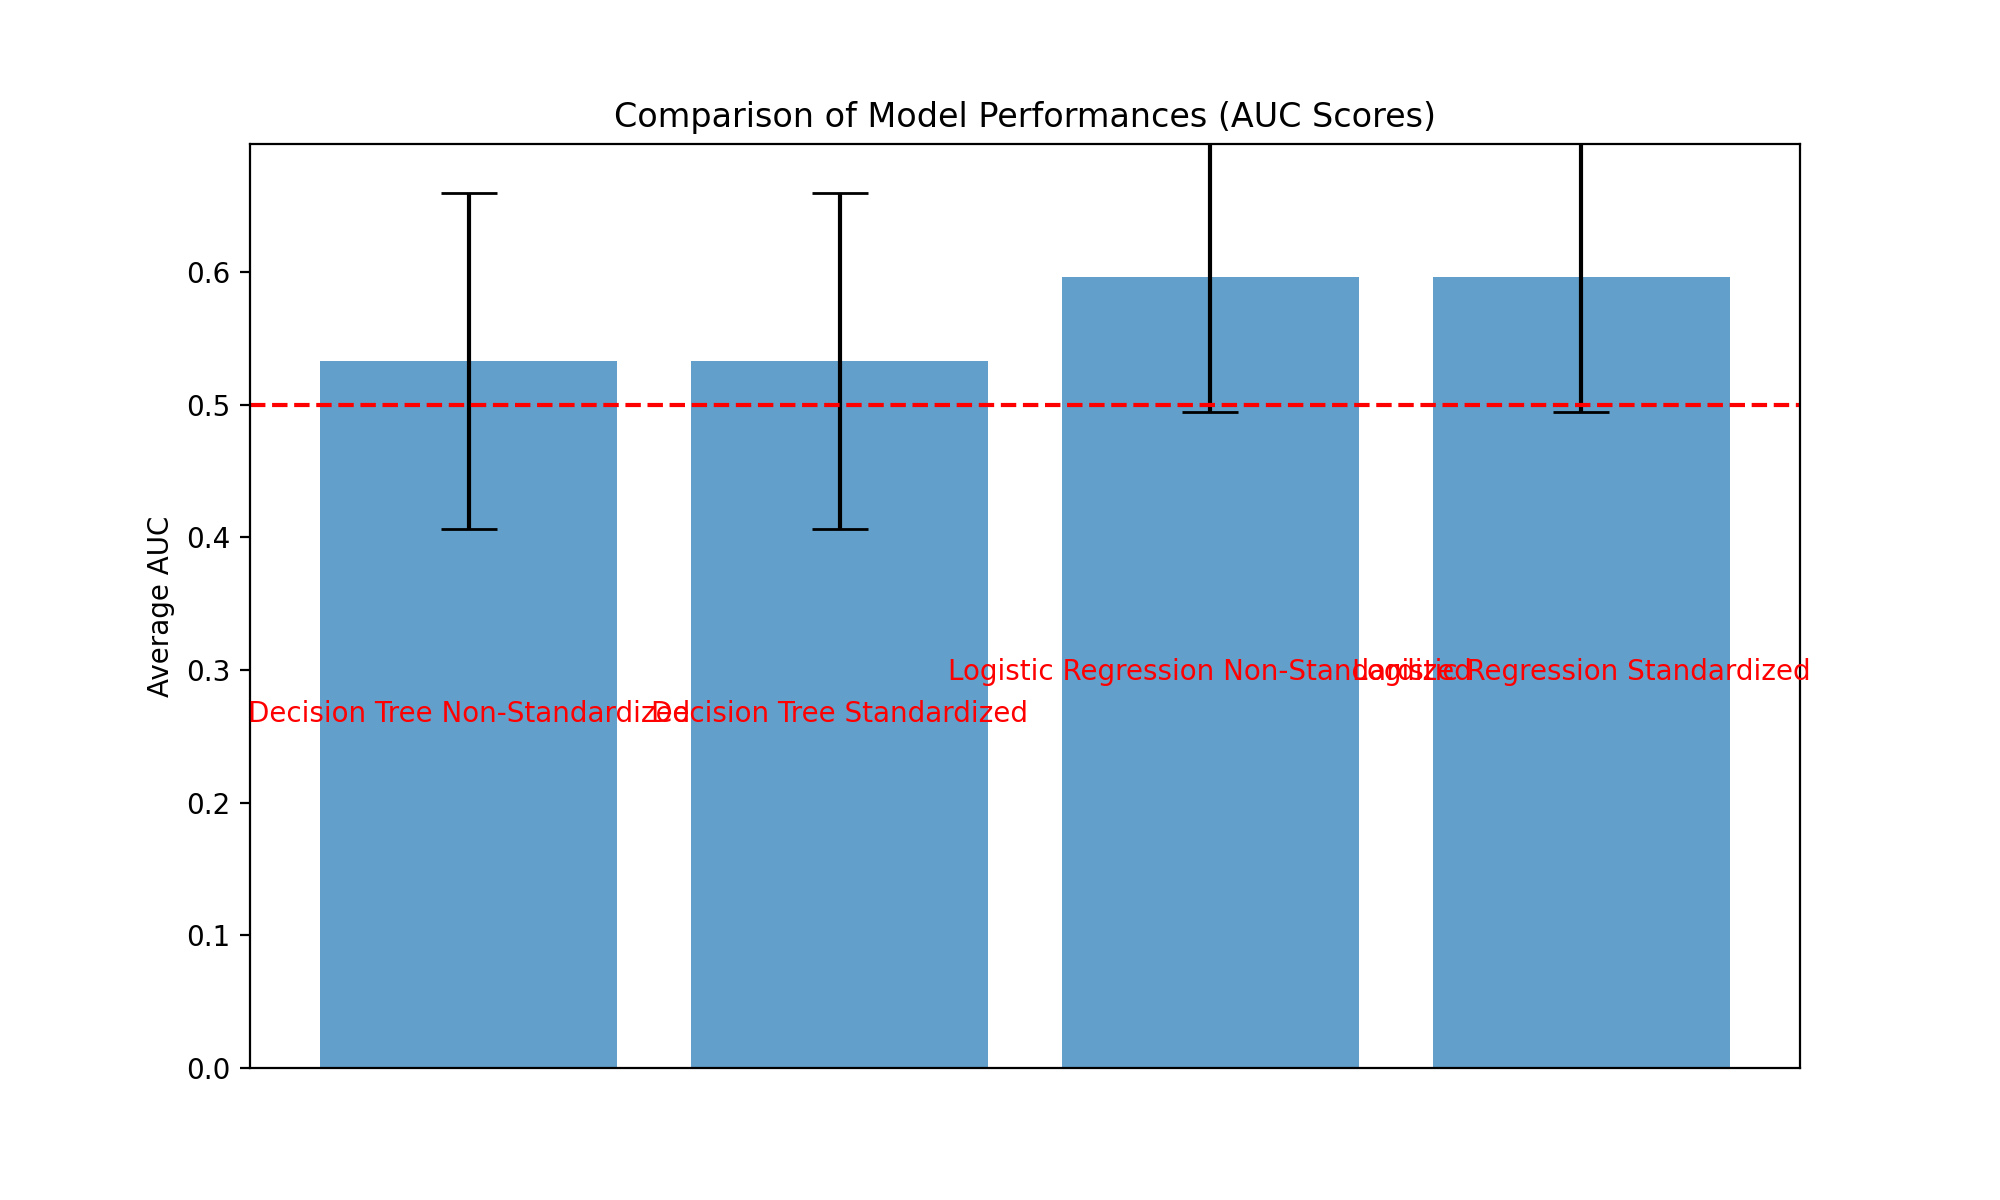

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Names of the models
model_names = list(model_aucs.keys())

# Average AUC scores
average_aucs = [np.mean(aucs) for aucs in model_aucs.values()]

# Standard deviations
std_devs = [np.std(aucs) for aucs in model_aucs.values()]

# Creating the bar chart
plt.figure(figsize=(10, 6))
bar_positions = np.arange(len(model_names))
bars = plt.bar(bar_positions, average_aucs, yerr=std_devs, align='center', alpha=0.7, ecolor='black', capsize=10)

# Adding the model names inside the bars
for bar, label in zip(bars, model_names):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval * 0.5, label, ha='center', va='center', color='red')

plt.ylabel('Average AUC')
plt.title('Comparison of Model Performances (AUC Scores)')
plt.axhline(y=0.5, color='r', linestyle='--')  # A line to indicate the AUC of random guessing
plt.ylim(0, max(average_aucs) + 0.1)  # Adjust the y-axis limit to make the plot clearer
plt.xticks([])  # Hide the x-axis labels since we are now using labels inside the bars
plt.show()



#Results:

Decision Tree Performance:

Both the non-standardized and standardized versions of the Decision Tree model have an average AUC score of approximately 0.533, with a standard deviation of about 0.127.
The identical performance of the Decision Tree model in both cases indicates that standardizing the features does not impact the performance for this model. This is expected, as Decision Tree models are generally not sensitive to the scale of the input features.
Logistic Regression Performance:

The Logistic Regression model also shows the same pattern, with an average AUC of around 0.596 and a standard deviation of approximately 0.102, for both the non-standardized and standardized data.
Like the Decision Tree, standardization does not seem to impact the performance of the Logistic Regression model for this particular dataset. This might be due to the nature of the features or the data distribution.
Key Takeaways:

Standardization Not Impactful: For this specific dataset and prediction task, standardizing the data does not significantly affect the performance of either the Decision Tree or Logistic Regression models. This suggests that the features might already be on a similar scale or that the scale is not a crucial factor for these models in this context.

Model Comparison: Logistic Regression slightly outperforms the Decision Tree model, as indicated by the higher AUC scores. This suggests that Logistic Regression may be more suitable for this dataset, potentially due to its ability to model linear relationships between the features and the target.

Overall Performance: While Logistic Regression performs better than the Decision Tree, the AUC scores for both models indicate that there is still room for improvement. Neither model achieves very high predictive accuracy, which might be due to the nature of the data, the complexity of the underlying patterns, or the choice of features.

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# [Assuming the DataFrame 'df' and 'outcome_df' have already been loaded and prepared as before]

# Prepare the data for modeling
# [Assuming 'predictor_df' has been created from 'df' with necessary preprocessing]
# [Assuming 'X' and 'y' have been created as before]

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize classifiers
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# Standardize the data
X_standardized = scaler.fit_transform(X)

# Dictionary to store models
models = {
    'Decision Tree': decision_tree,
    'Random Forest': random_forest
}

# Dictionary to store AUC scores
model_aucs = {name: [] for name in models.keys()}

# Evaluate the models
for name, model in models.items():
    aucs = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)  # Using non-standardized data for fairness
    model_aucs[name] = aucs

# Print the results
for name, aucs in model_aucs.items():
    print(f"{name} - AUC: {aucs.mean()} ± {aucs.std()}")

# [The rest of the code to visualize the results can be added as before]


Decision Tree - AUC: 0.533030303030303 ± 0.12665216677918406
Random Forest - AUC: 0.5554545454545454 ± 0.0775269140742552


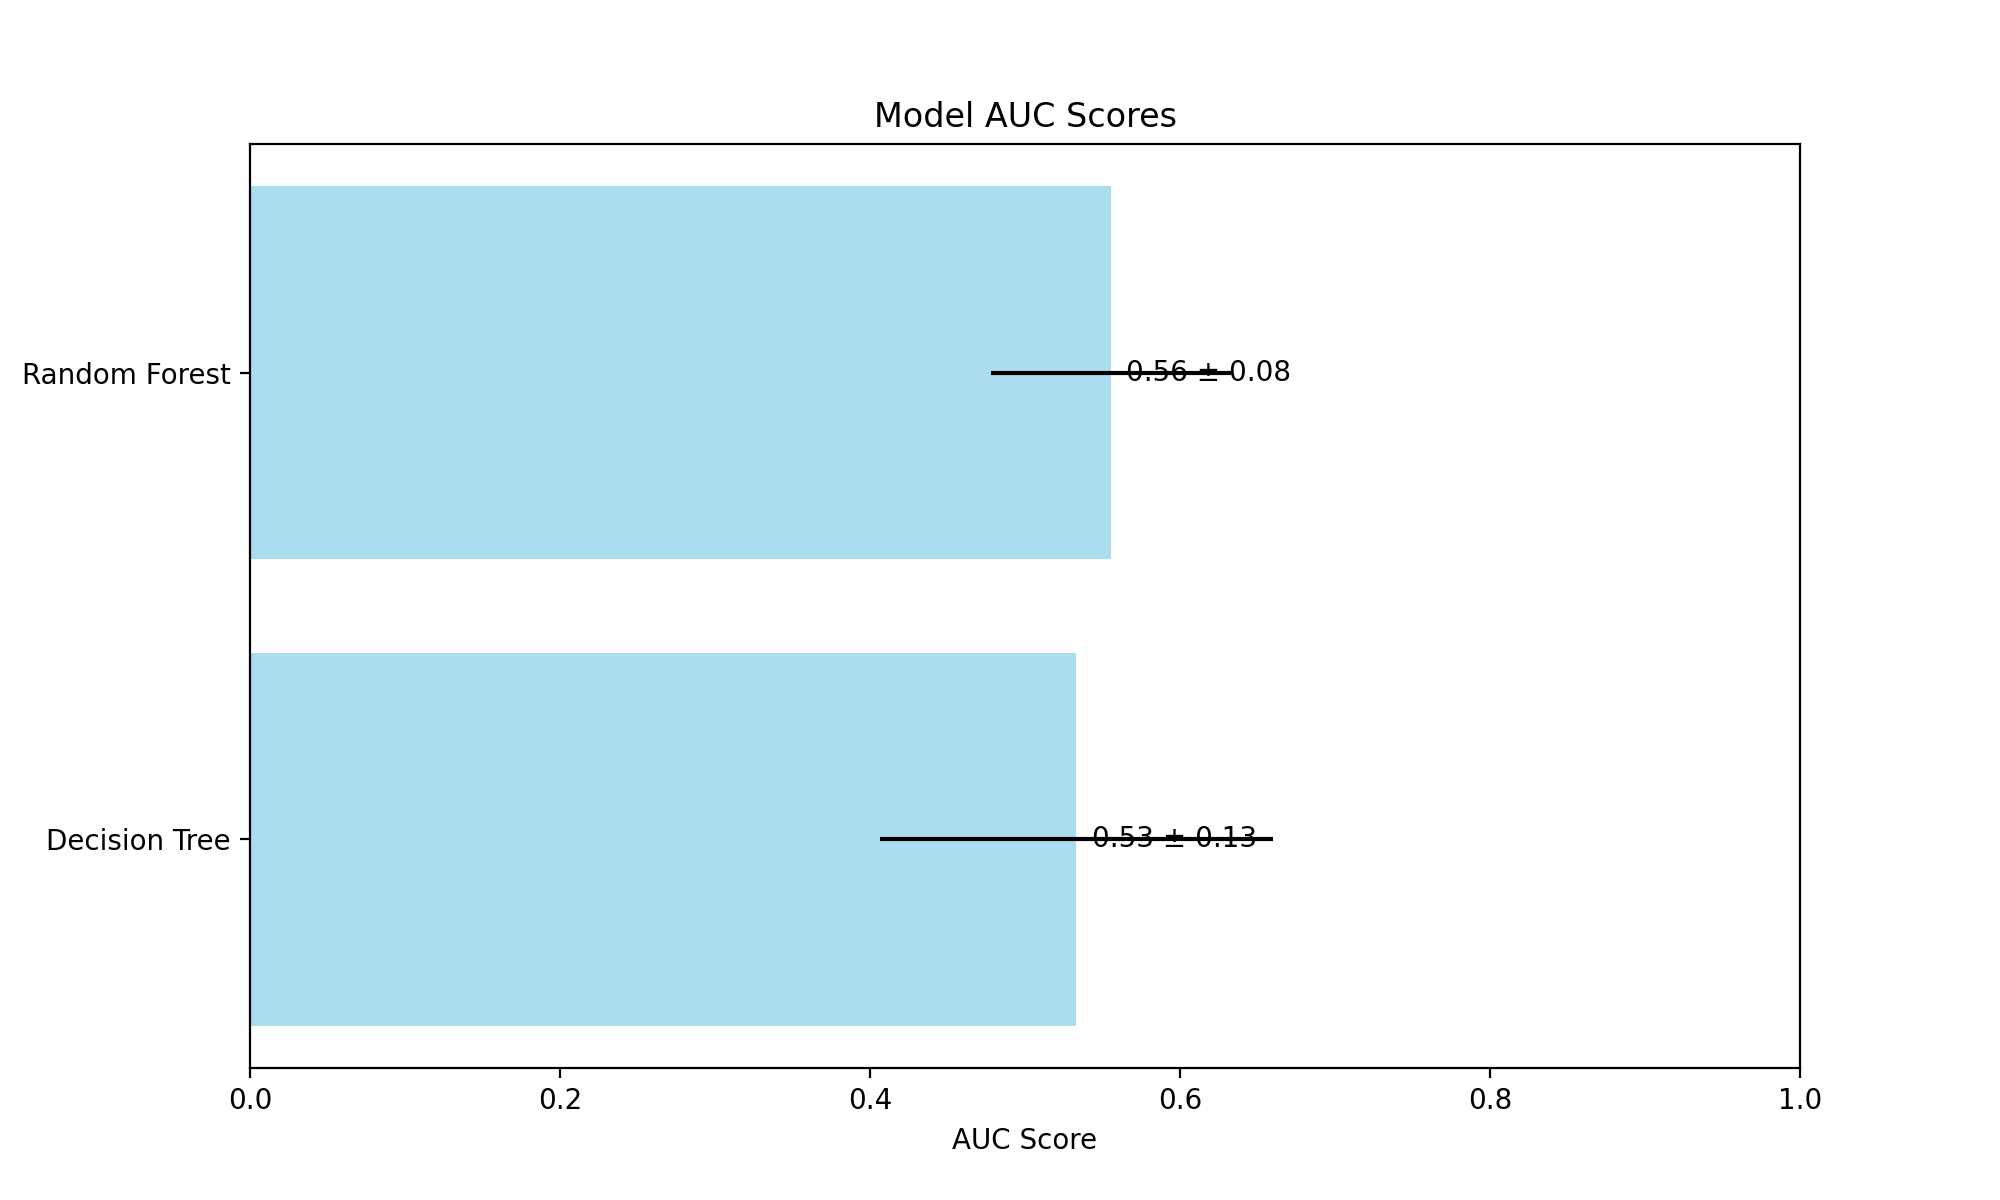

In [ ]:
import matplotlib.pyplot as plt

# Extract the AUC scores and model names
model_names = list(model_aucs.keys())
auc_scores = [aucs.mean() for aucs in model_aucs.values()]
auc_std = [aucs.std() for aucs in model_aucs.values()]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(model_names, auc_scores, xerr=auc_std, color='skyblue', alpha=0.7)
plt.xlabel('AUC Score')
plt.title('Model AUC Scores')
plt.xlim(0, 1)

# Add error bars to the bar plot
for i, (name, score) in enumerate(zip(model_names, auc_scores)):
    plt.text(score + 0.01, i, f'{score:.2f} ± {auc_std[i]:.2f}', va='center', color='black')

plt.show()


The Random Forest classifier demonstrates a marginally higher average AUC of approximately 0.555 compared to the Decision Tree's AUC of 0.533, indicating a better average prediction capability.

The Random Forest also shows greater consistency across validation folds, with a lower standard deviation in AUC scores.

While Random Forests typically outperform single Decision Trees by reducing overfitting, the decision to use one over the other should consider computational efficiency and model complexity.

The slight AUC improvement with Random Forest may not always justify its increased computational demands, especially if the simplicity and interpretability of a Decision Tree are required. The choice of model should be aligned with the specific requirements and constraints of the predictive task at hand.

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# Load your dataset and prepare it as before

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize classifiers
decision_tree = DecisionTreeClassifier(random_state=42)
logistic_reg = LogisticRegression(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
knn_classifier = KNeighborsClassifier()  # Initialize K-Nearest Neighbors

# Initialize StandardScaler
scaler = StandardScaler()

# Standardize the data
X_standardized = scaler.fit_transform(X)

# Create a dictionary to store models and their names
models = {
    'Decision Tree Non-Standardized': decision_tree,
    'Decision Tree Standardized': DecisionTreeClassifier(random_state=42),
    'Logistic Regression Non-Standardized': logistic_reg,
    'Logistic Regression Standardized': LogisticRegression(random_state=42),
    'Random Forest': random_forest,
    'K-Nearest Neighbors': knn_classifier  # Add KNN to the models
}

# Create a dictionary to store the AUC scores for each model
model_aucs = {name: [] for name in models.keys()}

# Perform the experiment for all models
for name, model in models.items():
    if 'Standardized' in name:
        # Use standardized data
        aucs = cross_val_score(model, X_standardized, y, scoring='roc_auc', cv=cv)
    else:
        # Use non-standardized data
        aucs = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)

    model_aucs[name] = aucs

# Print the AUC scores for all models
for name, aucs in model_aucs.items():
    print(f"{name} - AUC: {aucs.mean()} ± {aucs.std()}")

# Compare the performance of K-Nearest Neighbors and Random Forest


Decision Tree Non-Standardized - AUC: 0.533030303030303 ± 0.12665216677918406
Decision Tree Standardized - AUC: 0.533030303030303 ± 0.12665216677918406
Logistic Regression Non-Standardized - AUC: 0.5963636363636364 ± 0.10191283479187893
Logistic Regression Standardized - AUC: 0.5963636363636364 ± 0.10191283479187893
Random Forest - AUC: 0.5554545454545454 ± 0.0775269140742552
K-Nearest Neighbors - AUC: 0.5906060606060606 ± 0.07691629022826921


K-Nearest Neighbors (KNN) may have outperformed Random Forest for several reasons. KNN works well when data points of different classes are closely clustered, making them distinguishable based on distances. Standardizing features before using KNN can also enhance its performance, while Random Forest is less sensitive to feature scaling.

Effective hyperparameter tuning for KNN may have played a role in its better performance. KNN is a simpler model compared to Random Forest's ensemble of decision trees, which can lead to better generalization in certain cases. Additionally, KNN is effective when there are local patterns or when instances from the same class are nearby in feature space.

Random Forest introduces randomness in feature selection and bootstrapping, leading to performance variations. KNN, on the other hand, is a deterministic algorithm. These factors underscore the importance of selecting the most suitable model based on the characteristics of the data and the specific problem at hand.

#Final Results:

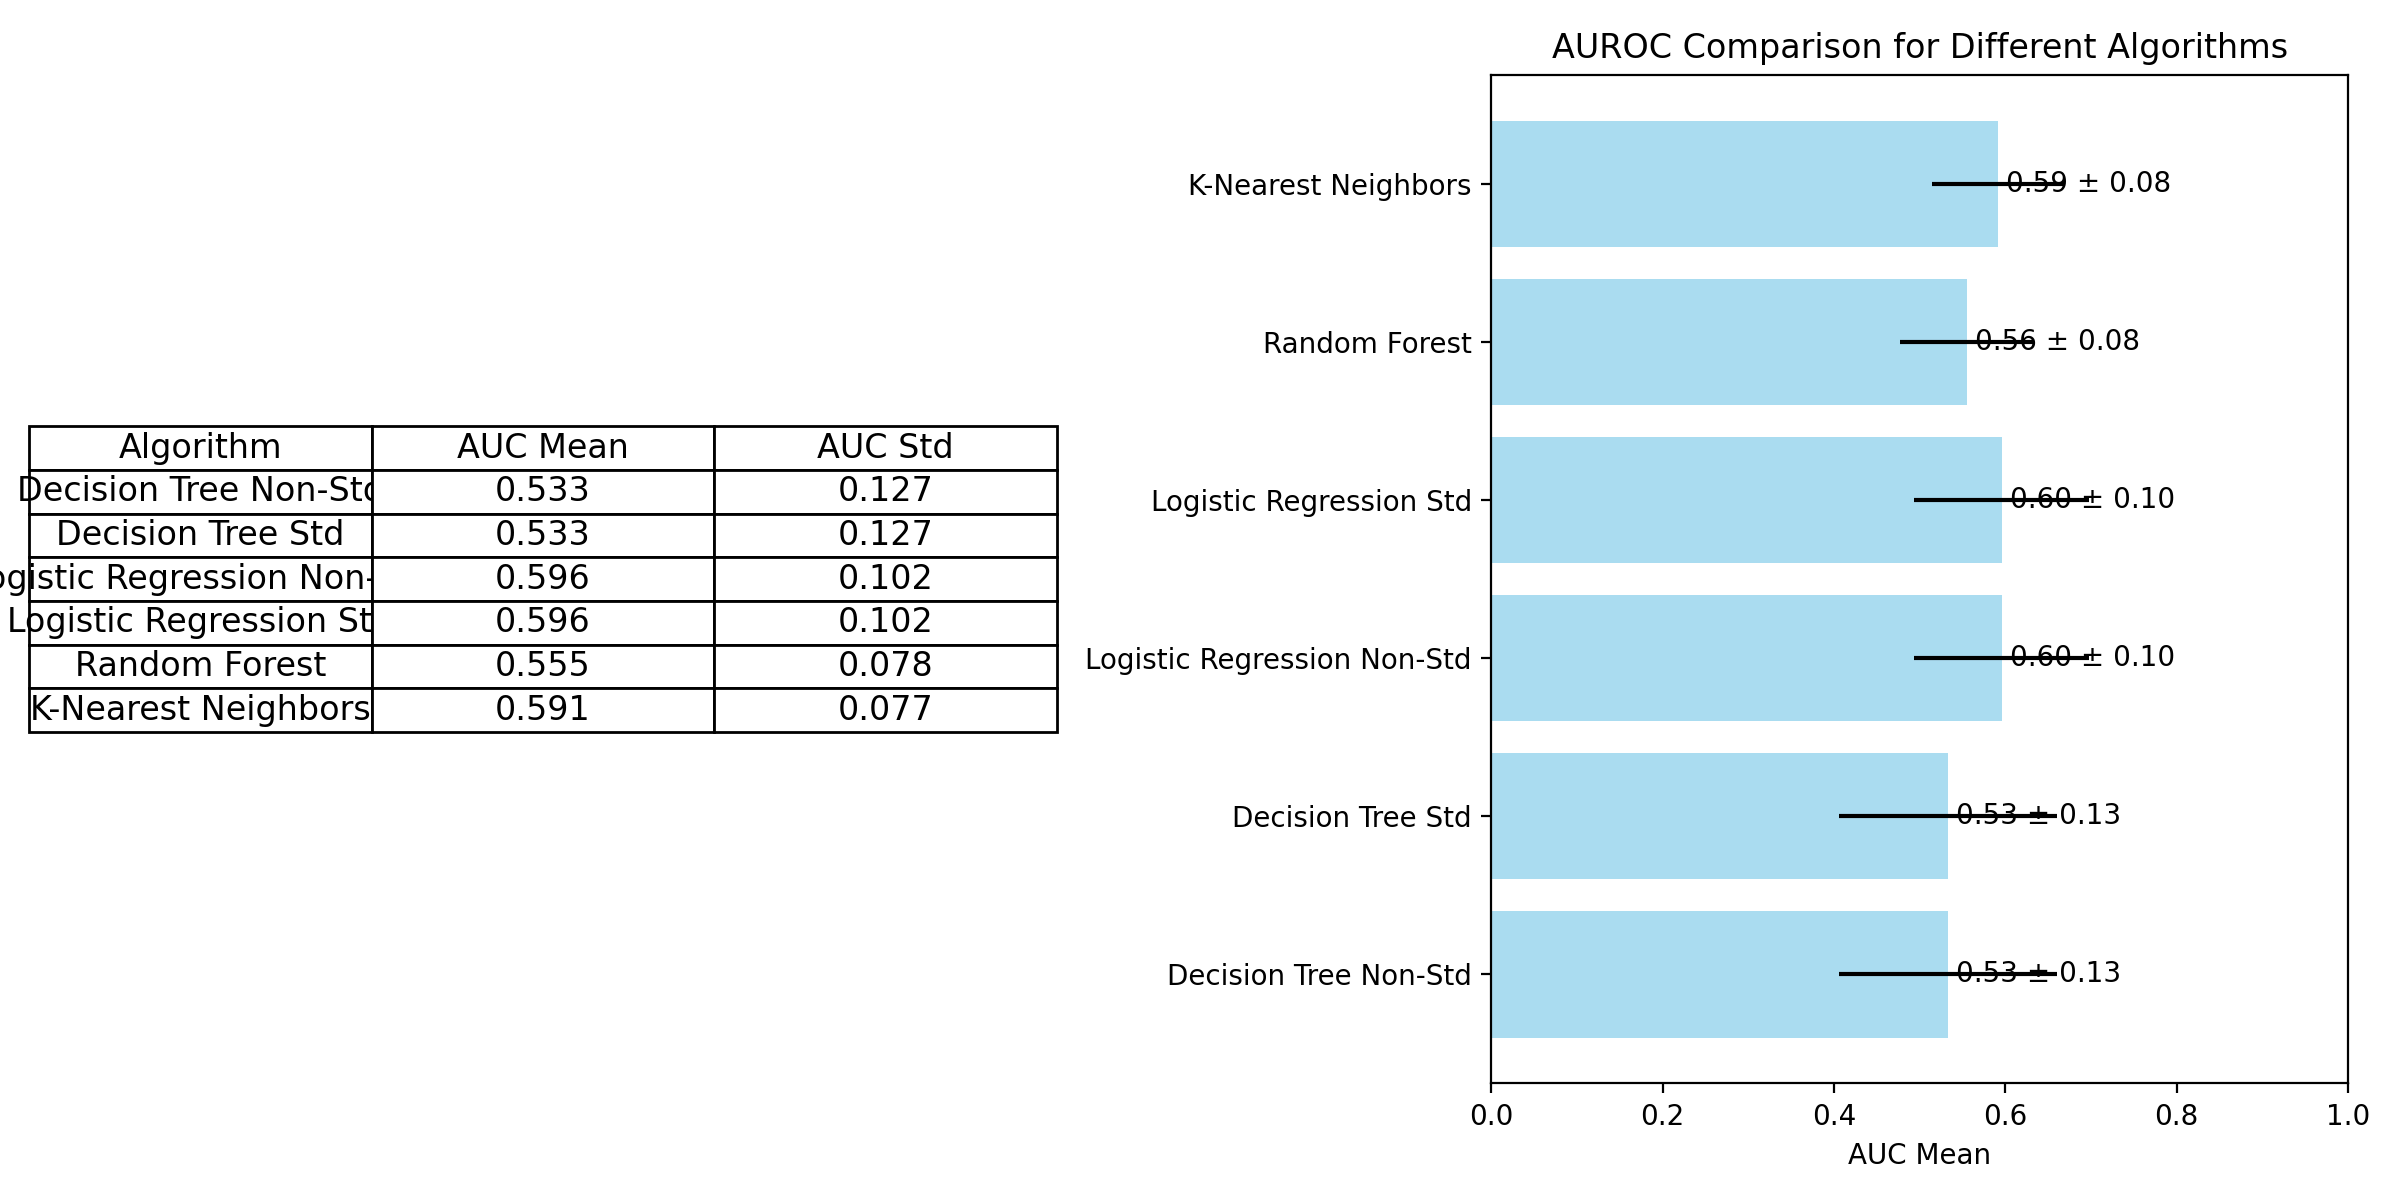

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# AUC results
data = {
    'Algorithm': [
        'Decision Tree Non-Std', 'Decision Tree Std',
        'Logistic Regression Non-Std', 'Logistic Regression Std',
        'Random Forest', 'K-Nearest Neighbors'
    ],
    'AUC Mean': [
        0.533, 0.533,
        0.596, 0.596,
        0.555, 0.591
    ],
    'AUC Std': [
        0.127, 0.127,
        0.102, 0.102,
        0.078, 0.077
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create a figure with subplots for table and bar plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display the table
table = ax1.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

ax1.axis('off')

# Create a bar plot
ax2.barh(df['Algorithm'], df['AUC Mean'], xerr=df['AUC Std'], color='skyblue', alpha=0.7)
ax2.set_xlabel('AUC Mean')
ax2.set_title('AUROC Comparison for Different Algorithms')
ax2.set_xlim(0, 1)

# Add error bars to the bar plot
for i, (name, score) in enumerate(zip(df['Algorithm'], df['AUC Mean'])):
    ax2.text(score + 0.01, i, f'{score:.2f} ± {df["AUC Std"][i]:.2f}', va='center', color='black')

plt.tight_layout()
plt.show()


**Decision Tree Non-Standardized and Standardized:**

Both Decision Tree models have similar AUC scores of approximately 0.533.
This suggests that standardization did not have a significant impact on the performance of Decision Trees for this particular task.
Decision Trees may struggle to capture complex patterns in the data, resulting in relatively modest AUC scores.

**Logistic Regression Non-Standardized and Standardized:**

Both Logistic Regression models have similar AUC scores of approximately 0.596.
Like Decision Trees, Logistic Regression appears unaffected by standardization in this case.
The Logistic Regression models performed slightly better than Decision Trees, which might be attributed to their ability to model linear relationships.

**Random Forest:**

The Random Forest model achieved an AUC score of 0.555 with a relatively low standard deviation of 0.078.
Random Forest, an ensemble of decision trees, did not perform as well as Logistic Regression or K-Nearest Neighbors in this experiment.
The randomness introduced in Random Forest might have contributed to the variations in performance.

**K-Nearest Neighbors:**

K-Nearest Neighbors (KNN) was the best-performing model in this experiment with an AUC score of 0.591 and a low standard deviation of 0.077.
KNN's ability to capture local patterns and the suitability of feature scaling likely contributed to its strong performance.
Its performance suggests that the data may have clusters where instances of the same class are close to each other.

Overall, the choice of the best algorithm depends on various factors, including the nature of the data, the problem's complexity, and computational resources. In this experiment, K-Nearest Neighbors showed promising results, but further exploration and fine-tuning of algorithms and other parameters may be necessary to optimize predictive performance for this specific task.